In [173]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support

# Import Data

In [174]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
train_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_train_df_feats_OHE.csv')

test_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_test_df_feats_OHE.csv')

validation_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_val_df_feats_OHE.csv')




a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML


In [175]:
train_df.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus,evil
0,1,0,0,1,157,5,0,1,0,0,0,0,0,1,0
1,1,0,0,1,3,1,0,1,0,0,0,0,0,1,0
2,1,0,0,1,1010,0,0,1,0,0,0,0,0,1,0
3,1,1,0,0,21,2,2,0,0,0,0,0,1,1,0
4,1,1,0,0,1005,4,0,0,0,0,0,0,1,1,0


# Helpers

In [176]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue",'System_Core','Amazon_AWS','Container_Virtualization','Maintenance_Package_Management','Security_Monitoring','Utility_Misc']]
    labels = df['sus']
    return features, labels

In [177]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [178]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [179]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [180]:
train_df_feats, train_df_labels = split_data(train_df)
test_df_feats, test_df_labels = split_data(test_df)
val_df_feats, val_df_labels = split_data(validation_df)

In [181]:
train_df_feats.head()
train_df_feats.shape

(763144, 13)

In [182]:
train_df_labels.head()
train_df_labels.shape

(763144,)

In [183]:
train_df_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc
0,1,0,0,1,157,5,0,1,0,0,0,0,0
1,1,0,0,1,3,1,0,1,0,0,0,0,0
2,1,0,0,1,1010,0,0,1,0,0,0,0,0
3,1,1,0,0,21,2,2,0,0,0,0,0,1
4,1,1,0,0,1005,4,0,0,0,0,0,0,1


# Model training

## Isolation forest

In [184]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(train_df_feats)

IsolationForest(contamination=0.05, random_state=0)

In [185]:
ypred_iforest = iforest.predict(val_df_feats)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(val_df_labels, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.951     0.974    188181
           1      0.045     0.557     0.084       786

    accuracy                          0.950    188967
   macro avg      0.522     0.754     0.529    188967
weighted avg      0.994     0.950     0.970    188967



Accuracy:	0.950
Precision:	0.9940974094397117
Recall:		0.950
F1-Score:	0.970
Average Precision Score: 0.027194903519217054
Balanced Accuracy Score: 0.7542106306535883
Matthews Correlation Coefficient (MCC): 0.14881228803280538
AUC : 0.75421


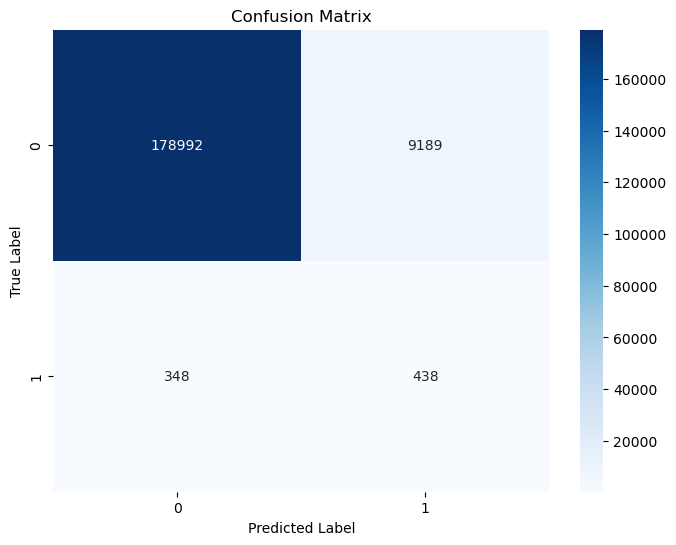

True Positives (TP): 438
True Negatives (TN): 178992
False Positives (FP): 9189
False Negatives (FN): 348


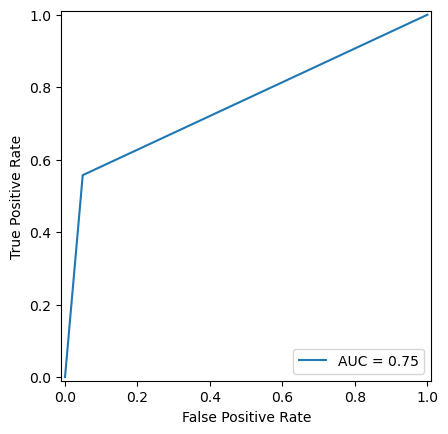

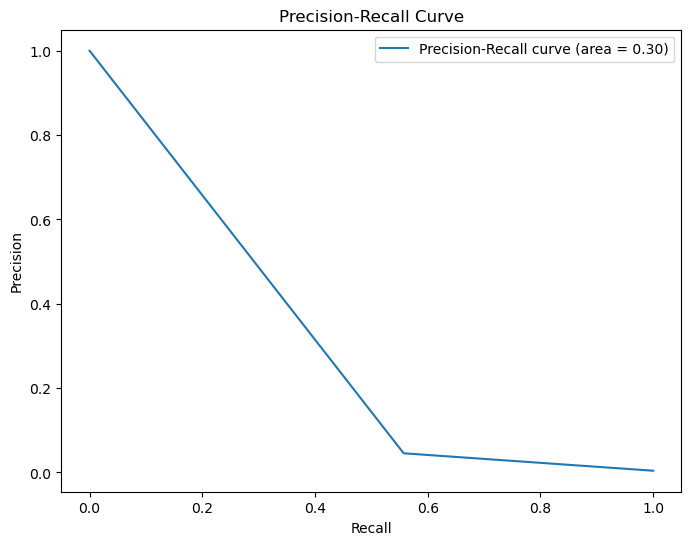

In [186]:
print_metrics(val_df_labels,ypred_iforest)

In [187]:
ypred_iforest_test = iforest.predict(test_df_feats)
ypred_iforest_test = prepare_labels(ypred_iforest_test)
print(classification_report(test_df_labels, ypred_iforest_test,digits=3))

              precision    recall  f1-score   support

           0      0.390     0.916     0.547     17508
           1      0.990     0.854     0.917    171459

    accuracy                          0.860    188967
   macro avg      0.690     0.885     0.732    188967
weighted avg      0.934     0.860     0.883    188967



Accuracy:	0.860
Precision:	0.9344473878809284
Recall:		0.860
F1-Score:	0.883
Average Precision Score: 0.977942924701019
Balanced Accuracy Score: 0.8848029333429368
Matthews Correlation Coefficient (MCC): 0.5408821018626137
AUC : 0.88480


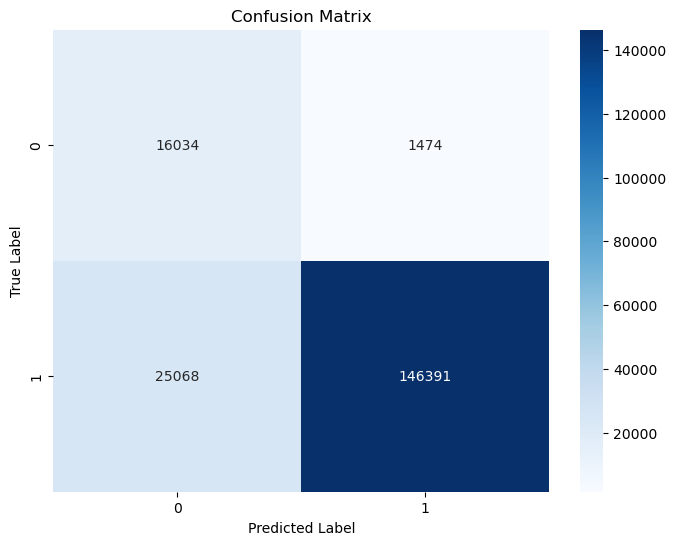

True Positives (TP): 146391
True Negatives (TN): 16034
False Positives (FP): 1474
False Negatives (FN): 25068


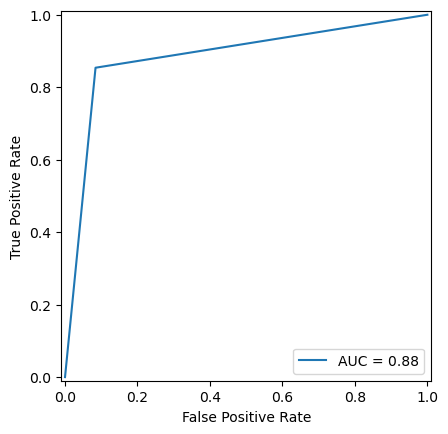

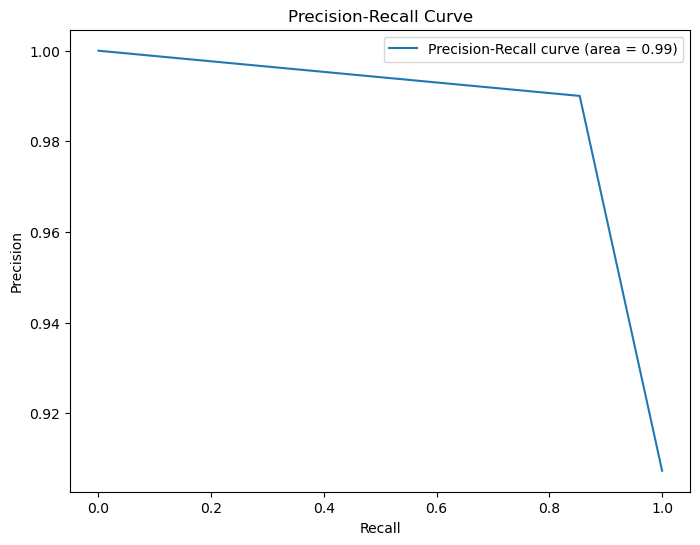

In [188]:
print_metrics(test_df_labels,ypred_iforest_test)

## Local Outlier Factor

In [189]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(train_df_feats)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [190]:
predicted_scores = lof.decision_function(test_df_feats)
predicted_labels = lof.predict(test_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.934
Precision:	0.935232915513281
Recall:		0.934
F1-Score:	0.934
Average Precision Score: 0.9635988097378
Balanced Accuracy Score: 0.8142765046598563
Matthews Correlation Coefficient (MCC): 0.6145505493476515
AUC : 0.81428


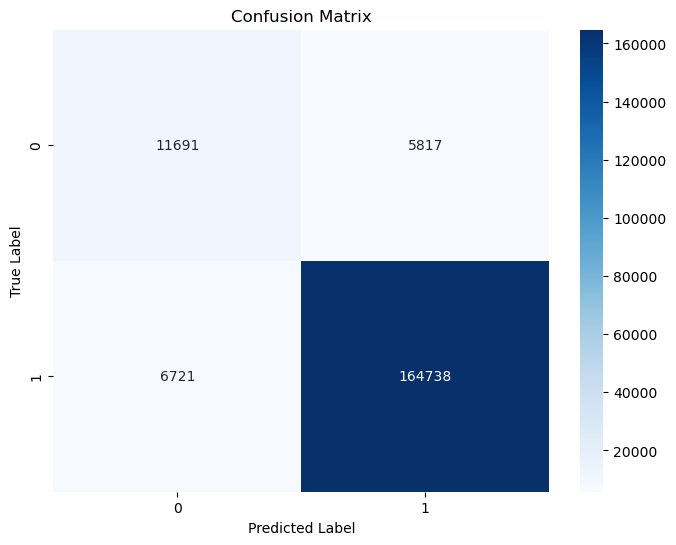

True Positives (TP): 164738
True Negatives (TN): 11691
False Positives (FP): 5817
False Negatives (FN): 6721


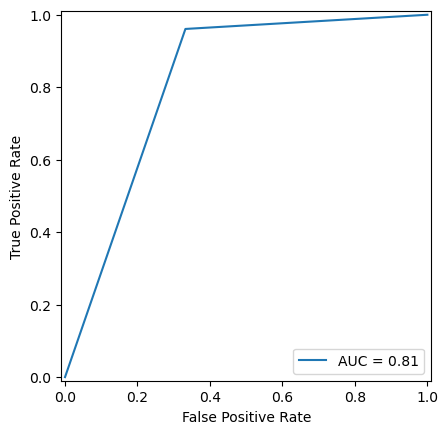

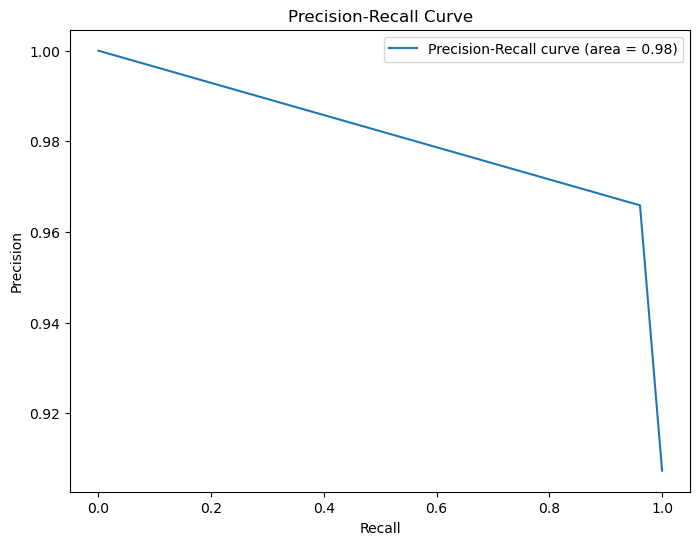

In [191]:
print_metrics(test_df_labels,predicted_labels)

In [192]:
predicted_scores = lof.decision_function(val_df_feats)
predicted_labels = lof.predict(val_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.994
Precision:	0.9925508634080076
Recall:		0.994
F1-Score:	0.993
Average Precision Score: 0.014047964302903686
Balanced Accuracy Score: 0.5389311618167193
Matthews Correlation Coefficient (MCC): 0.09813828697824163
AUC : 0.53893


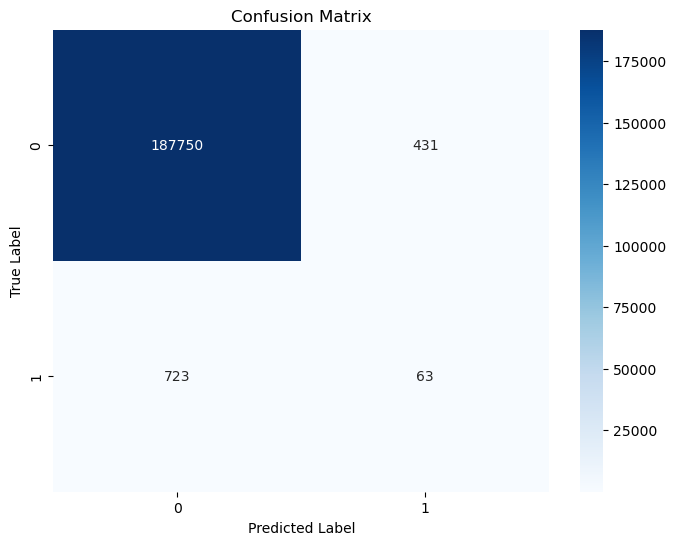

True Positives (TP): 63
True Negatives (TN): 187750
False Positives (FP): 431
False Negatives (FN): 723


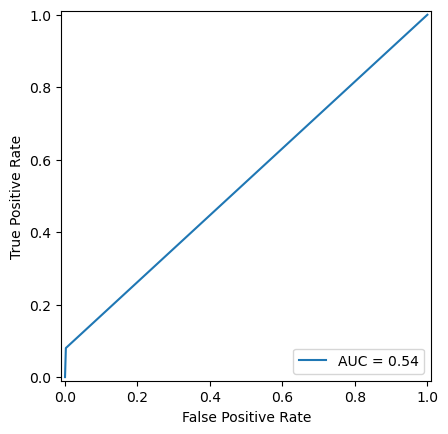

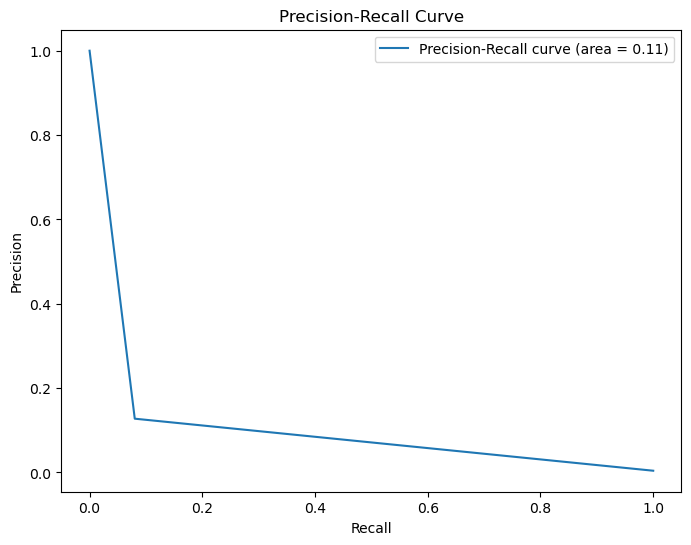

In [193]:
print_metrics(val_df_labels,predicted_labels)

## SVM

In [194]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(train_df_feats)

Accuracy:	0.701
Precision:	0.9910823536166431
Recall:		0.701
F1-Score:	0.821
Average Precision Score: 0.0038757132719504897
Balanced Accuracy Score: 0.4464956306683946
Matthews Correlation Coefficient (MCC): -0.015084973443520134
AUC : 0.44650


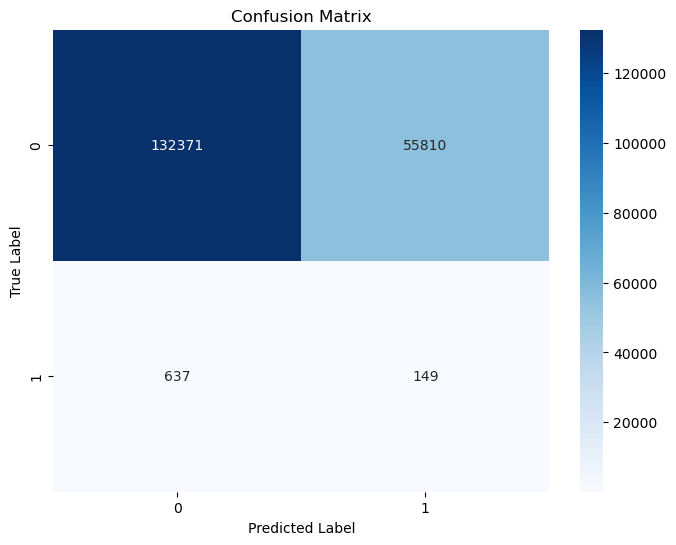

True Positives (TP): 149
True Negatives (TN): 132371
False Positives (FP): 55810
False Negatives (FN): 637


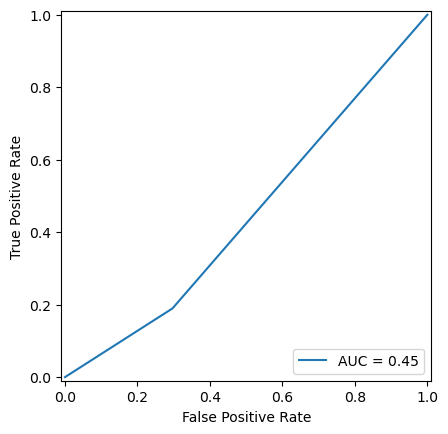

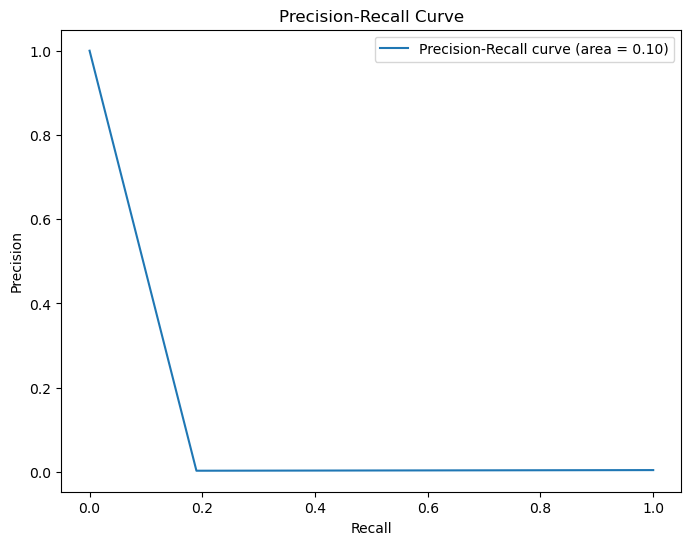

In [195]:
y_pred_svm_val = model.predict(val_df_feats)
y_pred_svm_val = prepare_labels(y_pred_svm_val)
print_metrics(val_df_labels,y_pred_svm_val)

Accuracy:	0.105
Precision:	0.5545655096019705
Recall:		0.105
F1-Score:	0.078
Average Precision Score: 0.8956140810884428
Balanced Accuracy Score: 0.39509056353714944
Matthews Correlation Coefficient (MCC): -0.26010006220217413
AUC : 0.39509


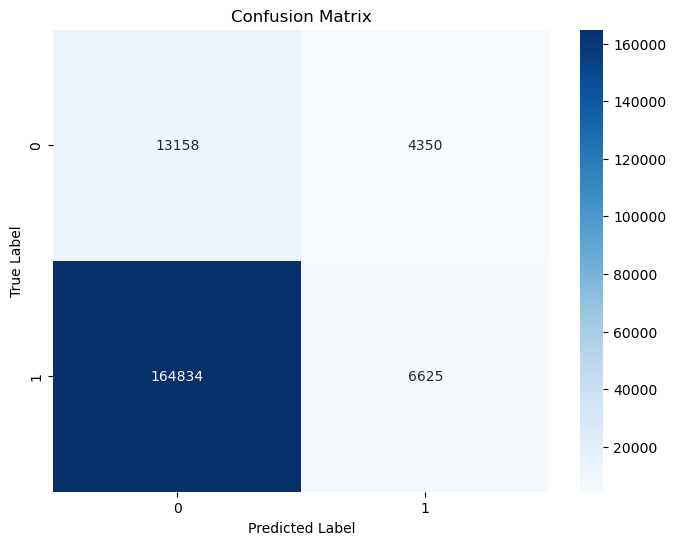

True Positives (TP): 6625
True Negatives (TN): 13158
False Positives (FP): 4350
False Negatives (FN): 164834


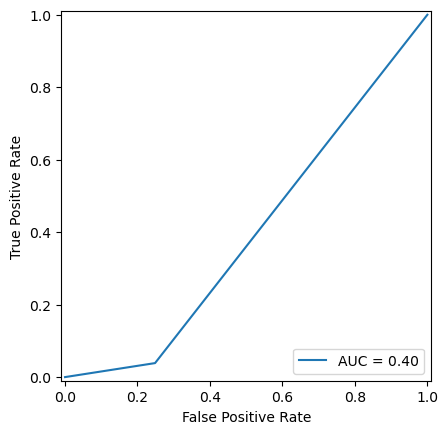

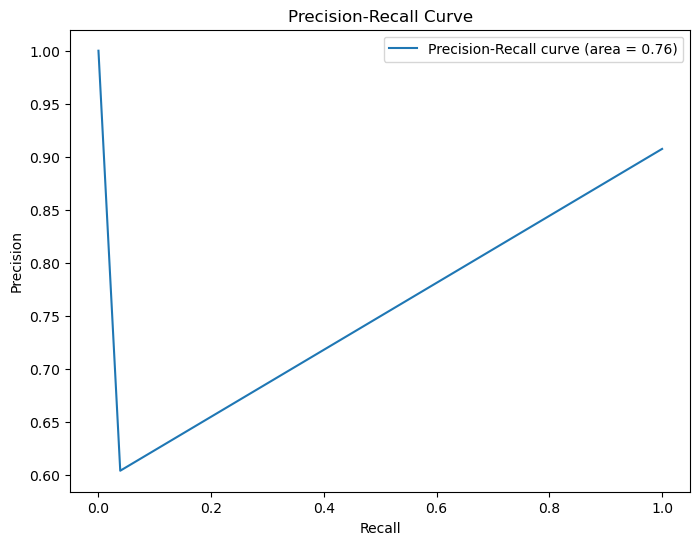

In [196]:
y_pred_svm_test = model.predict(test_df_feats)
y_pred_svm_test = prepare_labels(y_pred_svm_test)
print_metrics(test_df_labels,y_pred_svm_test)

## Autoenconder

In [197]:
input_dim = train_df_feats.shape[1] # Number of features

In [198]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = train_df_feats.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [199]:
checkpoint = ModelCheckpoint("best_weights3.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    train_df_feats, train_df_feats,
    epochs=20,
    batch_size=256,
    validation_data=(val_df_feats, val_df_feats),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights3.keras")

Epoch 1/20
2971/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 422.3146
Epoch 1: val_loss improved from inf to 0.00853, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 420.8806 - val_loss: 0.0085
Epoch 2/20
2975/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0803
Epoch 2: val_loss improved from 0.00853 to 0.00767, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0805 - val_loss: 0.0077
Epoch 3/20
2948/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2383
Epoch 3: val_loss did not improve from 0.00767
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2385 - val_loss: 0.2270
Epoch 4/20
2970/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3122
Epoch 4: val_loss did not improve from 0.00767
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3120 - val_loss: 0.0080
Epoch 5/20
2952/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1745
Epoch 5: val_loss did not improve from 0.00767
2982/2982 ━━━━━━━━━━━━━━━━━━━

In [200]:
# Predict on the test set
X_test_pred = autoencoder.predict(test_df_feats)
# Predict on the val set
X_val_pred = autoencoder.predict(val_df_feats)

X_train_pred = autoencoder.predict(train_df_feats)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 5s 762us/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 4s 759us/step
23849/23849 ━━━━━━━━━━━━━━━━━━━━ 18s 754us/step


In [201]:
mse_train = np.mean(np.power(train_df_feats - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(test_df_feats - X_test_pred, 2), axis=1)
mse_val = np.mean(np.power(val_df_feats - X_val_pred, 2), axis=1)

In [202]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [203]:
y_pred_val = (mse_val > threshold)
y_pred_val = y_pred_val.astype(int)

In [204]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(test_df_labels, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, mse_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.66      0.64      0.65     17508
           1       0.96      0.97      0.97    171459

    accuracy                           0.94    188967
   macro avg       0.81      0.81      0.81    188967
weighted avg       0.94      0.94      0.94    188967

AUC-ROC: 0.97


Accuracy:	0.936
Precision:	0.9357762008496516
Recall:		0.936
F1-Score:	0.936
Average Precision Score: 0.9619189925079028
Balanced Accuracy Score: 0.805545364024365
Matthews Correlation Coefficient (MCC): 0.6179617002352406
AUC : 0.80555


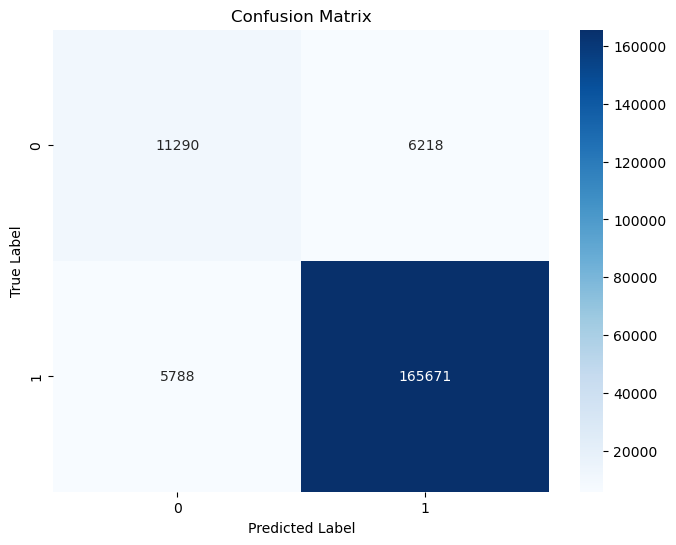

True Positives (TP): 165671
True Negatives (TN): 11290
False Positives (FP): 6218
False Negatives (FN): 5788


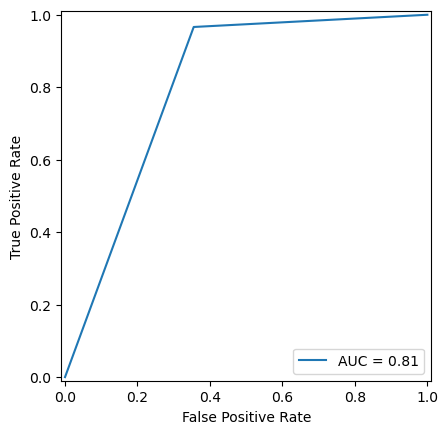

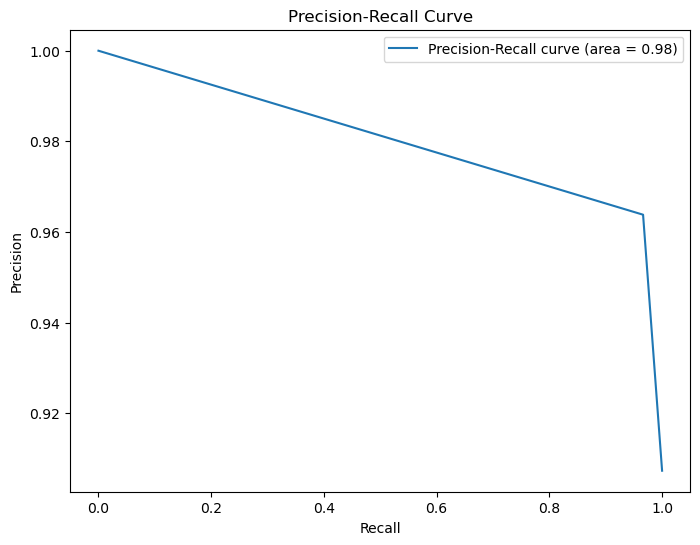

In [205]:
print_metrics(test_df_labels,y_pred_test)

In [206]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(val_df_labels, y_pred_val))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, mse_val) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    188181
           1       0.23      0.44      0.30       786

    accuracy                           0.99    188967
   macro avg       0.61      0.71      0.65    188967
weighted avg       0.99      0.99      0.99    188967

AUC-ROC: 0.49


Accuracy:	0.992
Precision:	0.9944368247457799
Recall:		0.992
F1-Score:	0.993
Average Precision Score: 0.10222153626773954
Balanced Accuracy Score: 0.7145069971005258
Matthews Correlation Coefficient (MCC): 0.3121788569015695
AUC : 0.71451


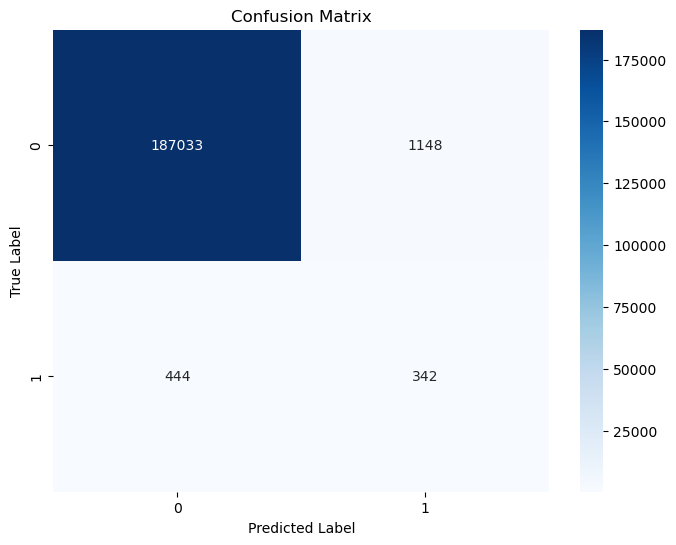

True Positives (TP): 342
True Negatives (TN): 187033
False Positives (FP): 1148
False Negatives (FN): 444


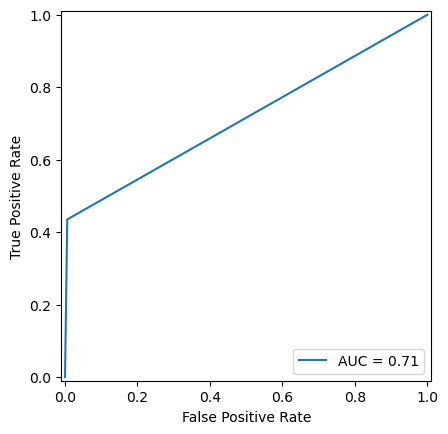

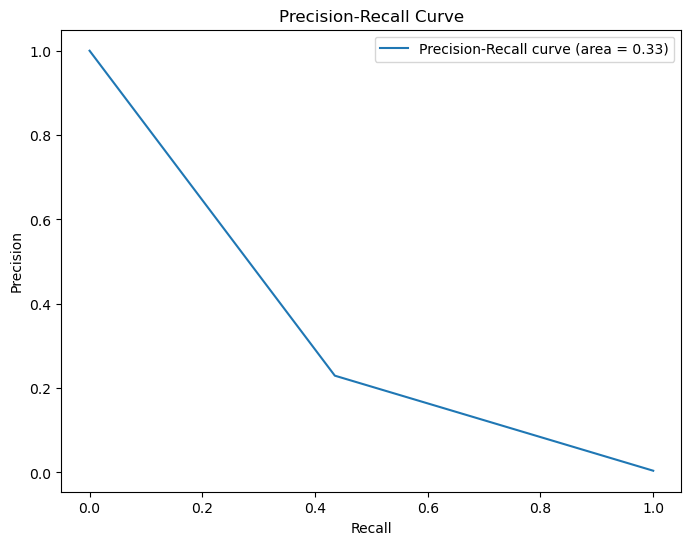

In [207]:
print_metrics(val_df_labels,y_pred_val)